In [1]:
import os, sys, gc, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import itertools
import seaborn as sns

from frontiers_colors import get_color
from frontiers_analysis import heaps, load_tissue, save_model, mazzolini, load_all_data

from tableanalyser import plotvarmen, plotcv2mean
from tacos_plot import scatterdense

In [2]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,scipy,matplotlib,seaborn -a Filippo_Valle -g -r -b -w

Filippo_Valle 
last updated: Wed Nov 25 2020 

CPython 3.8.6
IPython 7.19.0

pandas 1.1.4
numpy 1.19.4
scipy 1.5.3
matplotlib 3.3.2
seaborn 0.11.0

compiler   : GCC 7.5.0
system     : Linux
release    : 5.4.39-linuxkit
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : fc7295b29b1434f9414ef15c43809c1e4c079b8d
Git repo   : git@github.com:SilviaLazzardi/The_single_cell_transcriptome_as_a_component_system
Git branch : dvc_data
watermark 2.0.2


# Load Data

Choose one of these data source:
* mca for Mouse Cell Atlas (default)
* tm for Tabula Muris
* gtex for GTex

For Mouse Cell Atlas data will be automatically downloaded!

In [8]:
data_source = "mca"
os.system(f"mkdir -p {data_source}")
files = os.listdir(data_source)

In [ ]:
# Download all the files for MCA
from frontiers_analysis import get_files
get_files()

Please download the following files from original dataset
[https://figshare.com/s/865e694ad06d5857db4b](https://figshare.com/s/865e694ad06d5857db4b):
* *MCA_Figure2_Cell.Info.xlsx*
* *MCA_CellAssignments.csv*

They are required before run the following cells

In [ ]:
df_info = pd.read_excel("MCA_Figure2_Cell.Info.xlsx", index_col=0)

df_info['Tissue'] = list(map(lambda ann: ann.replace("Adult",""), df_info['Tissue'])) #remove adult or fetal
df_info['Tissue'] = list(map(lambda ann: ann.replace("Fetal",""), df_info['Tissue'])) #remove adult or fetal
df_info['Tissue'] = list(map(lambda ann: ann.replace("Neonatal",""), df_info['Tissue'])) #remove adult or fetal
df_info.info()

In [ ]:
df_file=pd.read_csv("MCA_CellAssignments.csv", index_col=0).set_index('Cell.name')
df_file['Cell_type'] = list(map(lambda ann: ann.split('(')[0].split(' ')[0], df_file['Annotation'])) #remove adult or fetal
df_file.info()

In [ ]:
df_info = df_file
df_info["id"] = df_file.index.values
df_info.rename(columns={'Tissue':'tissue',"id": "Cell_id"}, inplace=True)
df_info.info()

In [ ]:
files = list(filter(lambda f: "dge" in f,  os.listdir(data_source)))
files

# Analyse organs and store data
Here some files with all the analyses will be stored, this take a long time.

In [ ]:
print(files[0])

saved = []
frac_of = {}

if "mca" in data_source:
    data = pd.read_csv(f"{data_source}/{files[0]}", sep=" ")
    data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]

    #tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique() # only adults
    tissues = df_info[df_info['Cell_id'].isin(data.columns)]['tissue'].unique()

if "tm" in data_source:
    tissues = [files[0]]


print(tissues)
for tissue in tissues:
    if "mca" in data_source:
        df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
        #df = df.divide(df.sum(0), 1).applymap(lambda cpm: np.log(cpm*1e6+1)) #log(cpm +1)
    
    if "tm" in data_source:
        df = pd.read_csv(f"{data_source}/{files[0]}", sep=",", index_col=0) #tabula muris
        df = clean_df(df) #tabula muris
    
    A = df.sum(axis=1)
    O = df.apply(lambda x: len(x[x>0]), 1)
    M = df.apply(np.sum, 0)
    global_f = df.divide(M, axis=1).sum(1)
    cell_zeros = df.astype(int).apply(lambda x: len(x[x==0]), 0)
    gene_presence = df.apply(lambda x: len(x[~x.isna()]), 1).astype(int)
    gene_presence_nonnull = df.apply(lambda x: len(x[~x.isna() & (x>0)]), 1).astype(int)
    var = df.apply(lambda x: (x*x).sum(), 1)
    
    frac_of[tissue] = {'data': A,
                            'N': len(M)}
    
    diffWords = df.apply(lambda x: len(x[x>0]), 0)
    n_genes = {}
    n_genes[tissue] = diffWords
    
    n_expressed_genes = pd.Series(index=df.index, data=np.zeros_like(df.index))
    n_expressed_genes[A.sort_values(ascending=False).index[:100]]+=1
    save_model(df, "data", tissue)
    mazzolini(M, A/A.sum(), tissue)
    #heaps(M, diffWords, tissue)
    
    saved.append(tissue)
    df.to_csv(f"{data_source}/mainTable_{tissue}.csv", index=True, header=True)

In [ ]:
for file in files[1:]:
    print(file)
    if "mca" in data_source:
        data = pd.read_csv(f"{data_source}/{file}", sep=" ")
        data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]

        if len(data.columns) < 1:
            print(f"skipping {file} \n")
            continue
        #tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique() # only adults
        tissues = df_info[df_info['Cell_id'].isin(data.columns)]['tissue'].unique()

    if "tm" in data_source:
        data = pd.read_csv(f"{data_source}/{file}", sep=",", index_col=0)
        tissues = [files[0]]
    
    print(tissues)
    if len(tissues) < 1:
        print(f"no tissue found \n")
        continue
    for tissue in tissues:
        
        if "mca" in data_source:
            df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
        
        if "tm" in data_source:
            df = clean_df(data)
        
        if tissue in saved:
            df = df.transpose().append(pd.read_csv(f"{data_source}/mainTable_{tissue}.csv", index_col=0, header=0).transpose(), ignore_index=False, sort=True).transpose().fillna(0)
        
        #df = df.divide(df.sum(0), 1).applymap(lambda cpm: np.log(cpm*1e6+1)) #log(cpm +1)
        A_sub = df.sum(axis=1)
        O_sub = df.apply(lambda x: len(x[x>0]), 1)
        M_sub = df.apply(np.sum, 0)
        cell_zeros_sub = df.apply(lambda x: len(x[x>0]), 0)
        diffWords_sub = df.apply(lambda x: len(x[x>0]), 0)
        
        if tissue in frac_of.keys():
            frac_of[tissue]['data'].add(A_sub, fill_value = 0)
            frac_of[tissue]['N']+=len(M_sub)
        else:
            frac_of[tissue] = {'data': A_sub,
                                  'N': len(M_sub)}

        A = A.add(A_sub, fill_value=0)
        O = O.add(O_sub, fill_value=0)
        M = M.append(M_sub)
        global_f.add(df.divide(M_sub, axis=1).sum(1))
        cell_zeros = cell_zeros.append(cell_zeros_sub)
        diffWords = diffWords.append(diffWords_sub)
        if tissue in n_genes.keys():
            n_genes[tissue] = n_genes[tissue].append(diffWords_sub)
        else:
            n_genes[tissue]= diffWords_sub
        
        gene_presence = gene_presence.add(df.apply(lambda x: len(x[~x.isna()]), 1), fill_value=0)
        gene_presence_nonnull_sub = df.apply(lambda x: len(x[~x.isna() & (x>0)]), 1).astype(int)
        gene_presence_nonnull = gene_presence_nonnull.add(gene_presence_nonnull_sub, fill_value=0).astype(int)
        var = var.add(df.apply(lambda x: (x*x).sum(), 1), fill_value=0)
        
        n_expressed_genes_sub = pd.Series(index=df.index, data=np.zeros_like(df.index))
        n_expressed_genes_sub[A_sub.sort_values(ascending=False).index[:100]]+=1
        n_expressed_genes = n_expressed_genes.add(n_expressed_genes_sub, fill_value=0)

        save_model(df,"data",tissue)
        mazzolini(M_sub, A_sub/A_sub.sum(), tissue)
        #heaps(M_sub, diffWords_sub, tissue)
        saved.append(tissue)
        df.to_csv(f"{data_source}/mainTable_{tissue}.csv", index=True, header=True)
        print(f"Handling {len(M)} cells")

        del df 
        del A_sub
        del O_sub
        del M_sub
        del diffWords_sub
        del gene_presence_nonnull_sub
        gc.collect()
        print("\n")
    del tissues
    del data
    gc.collect()

means = A/gene_presence
means_nozero = A/gene_presence_nonnull
var = var/gene_presence - means*means
f = (A/A.sum())
O = O / gene_presence
O = O.reindex_like(means)
cv2 = var/means/means


print("Saving data.pkl")
data = {
    'means': means,
    'var': var,
    'freq': A/A.sum(),
    'O': O,
    'M': M,
    'cv2': cv2,
    'diffWords': diffWords,
    'means_nonzero': means_nozero,
    'n_expressed': n_expressed_genes,
    'n_genes': n_genes,
    'frac_of': frac_of,
    'cell_zeros': cell_zeros
}

with open("data_all.pkl","wb") as file:
    pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

# Load already done analyses

In [6]:
data = load_all_data("mca")

# Correlations with Tabula Muris

In [13]:
from scipy.stats import pearsonr

In [6]:
common_organs = ["Bladder", "Kidney", "Liver", "Lung", "Pancreas", "Spleen"]

organ = common_organs[3]

In [10]:
tm = load_all_data("tm")["freq"]
mca = load_all_data("mca")["freq"]
organ="all"

#tm = load_tissue(f"{organ}-counts.csv", data_source="tm")["freq"]
#mca = load_tissue(f"{organ}", data_source="mca")["freq"]

tm = tm[tm.index.isin(mca.index)]
mca = mca[mca.index.isin(tm.index)]
tm = pd.Series(name='tm',index=tm.sort_values(ascending=False).index, data=range(1,1+len(tm)))
mca = pd.Series(name='mca',index=mca.sort_values(ascending=False).index, data=range(1, len(mca)+1))

mca = mca.reindex_like(tm).dropna()
tm = tm.reindex_like(mca).dropna()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


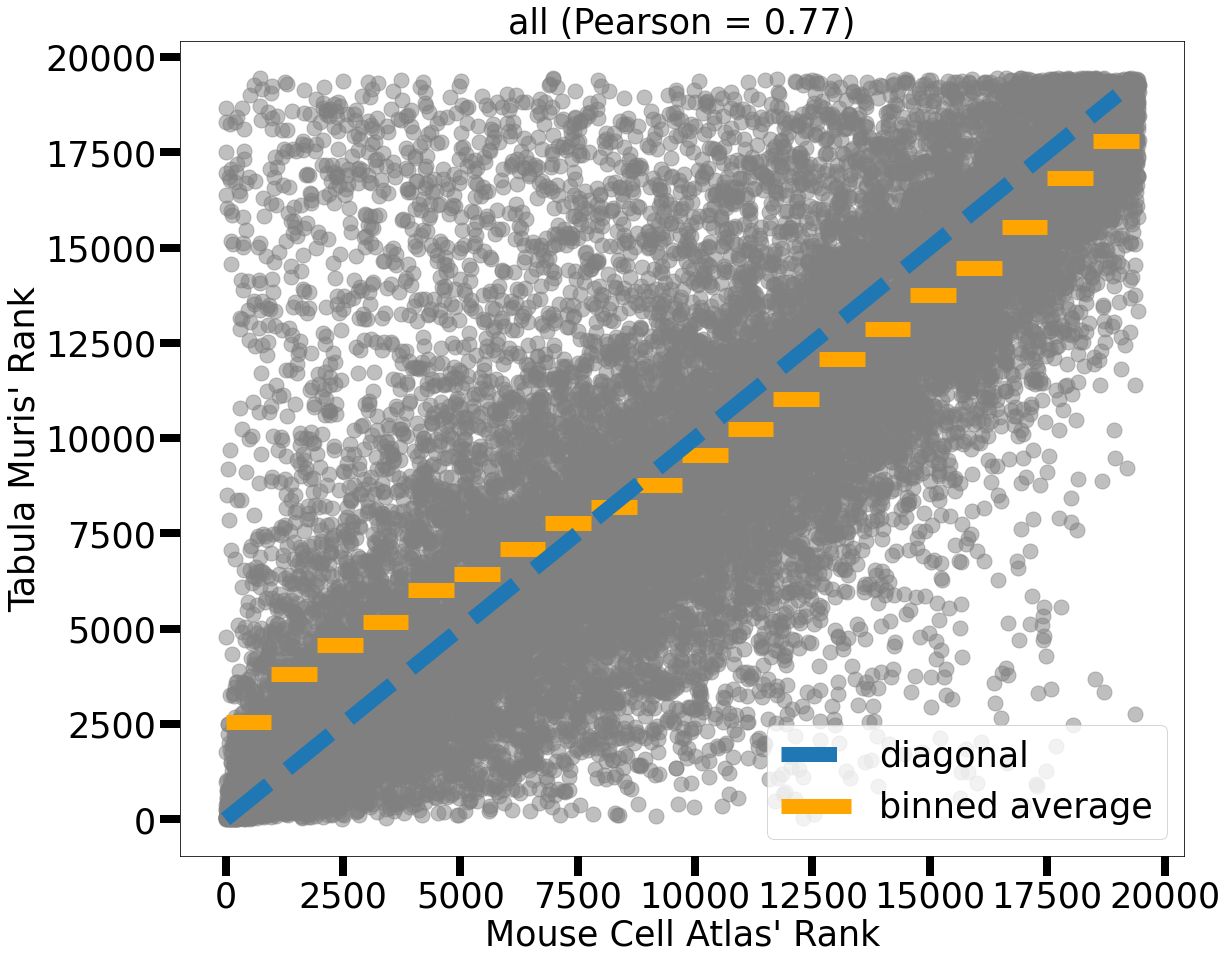

In [14]:
fig, ax = plt.subplots(figsize=(18,15))
ax.scatter(mca.values,tm.values, c="gray", s=225, alpha=0.5)

bin_avg, bin_edges, _ = stats.binned_statistic(mca.values, tm.values,"mean", bins=20)
ax.plot(np.linspace(0,1.9e4), np.linspace(0,1.9e4), lw=15, ls="--", label="diagonal")
ax.hlines(bin_avg, bin_edges[:-1], bin_edges[1:], lw=15, ls="-", color="orange", label="binned average")

ax.set_title(f"{organ} (Pearson = %.2f)"%(pearsonr(mca.values, tm.values)[0]), fontsize=35)
ax.set_xlabel("Mouse Cell Atlas' Rank", fontsize=35)
ax.set_ylabel("Tabula Muris' Rank", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)
ax.legend(loc="lower right", fontsize=35)
fig.savefig(f"rank_correlation_{organ}.pdf")
fig.savefig(f"rank_correlation_{organ}.eps")

fig.savefig("rank_correlation.pdf")
plt.show()

# Fraction of trascriptome described

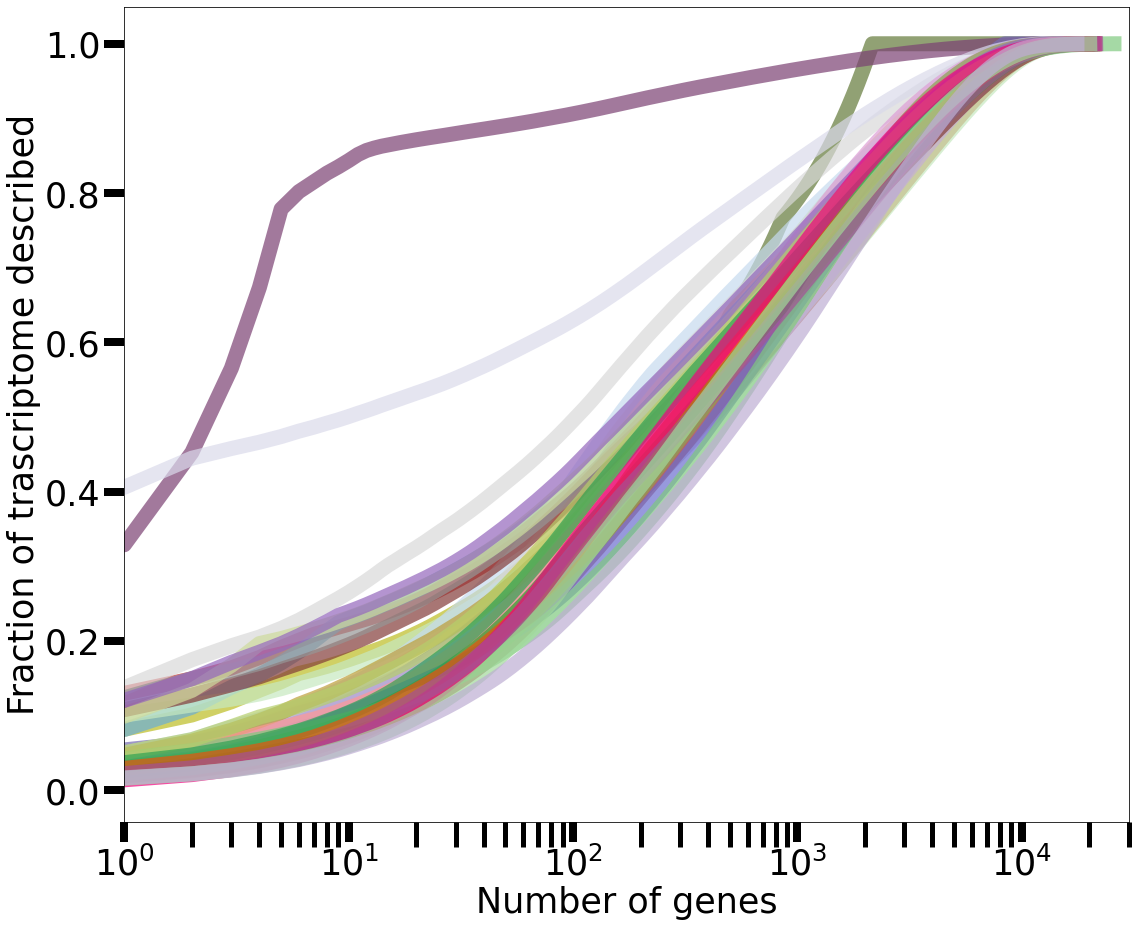

In [12]:
thresholded = {}

frac_of = data["frac_of"]

fig,ax = plt.subplots(figsize=(18,15))
for tissue in frac_of.keys():
    #if "Lactation" in tissue:
    #    continue
    A_tissue = (frac_of[tissue]['data'] / frac_of[tissue]['N']).sort_values(ascending=False)
    A_tissue_sum = np.cumsum(A_tissue.values) / A_tissue.sum() #h thr
    ax.plot(A_tissue_sum, label = tissue, c=get_color(tissue), lw=15, alpha=.7)
    #if len(A_tissue_sum) < 2:
    #    continue
    thresholded[tissue] = A_tissue_sum[99]
    #thresholded[tissue] = np.argwhere(A_tissue_sum>=0.4).ravel()[0] #v thr
ax.set_xscale('log')
ax.set_xlim(1, 3e4)
ax.set_xlabel("Number of genes", fontsize=35)
ax.set_ylabel("Fraction of trascriptome described", fontsize=35)

# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)


# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
fig.savefig("fracof_mca.pdf")

# All Tissues

## Zipf

<class 'FileNotFoundError'> [Errno 2] No such file or directory: '../../mca/data_Fetal_Kidney_data.pkl' <traceback object at 0x7f322eff0e80>


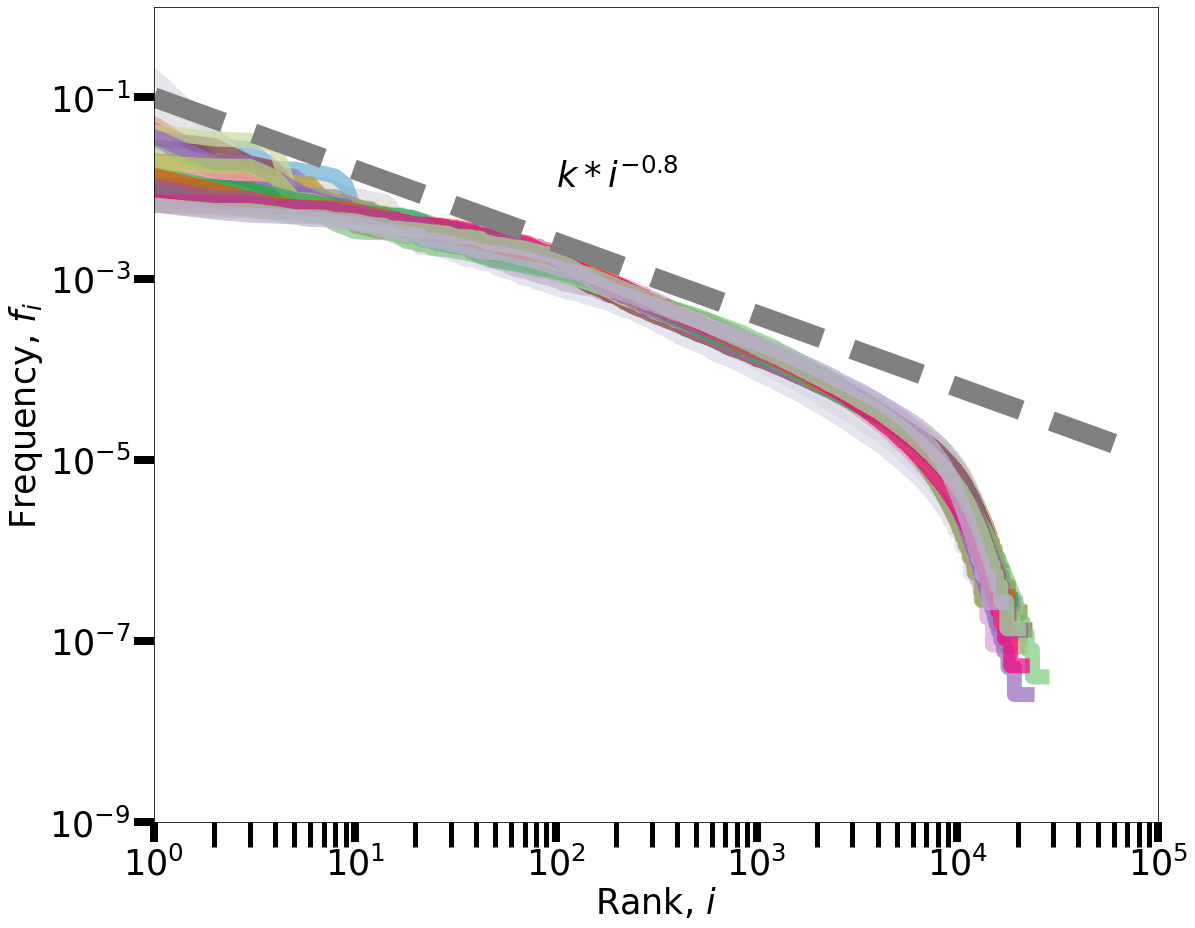

In [10]:
fig, ax = plt.subplots(figsize=(18,15))
for tissue in data["frac_of"].keys():
    try:
        info = load_tissue(tissue, data_source=data_source)
    except:
        print(*sys.exc_info())
        continue 
    if "Lactation" in tissue:
        continue
    f = info["freq"]
    ax.plot(f.sort_values(ascending=False).values, label=tissue, c=get_color(tissue), lw=15, alpha=.7)
    
x =np.linspace(1,6e4,10)

exp = 0.8
ax.plot(x, 1e-1*np.power(x, -0.8), lw=20, c='gray', ls='--')

ax.set_xscale("log")
ax.set_yscale("log")

ax.annotate('$k*i^{-%.1f}$'%exp, (1e2,1e-2), fontsize=35)

# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, ncol=2)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
ax.set_xlabel("Rank, $i$", fontsize=35)
ax.set_ylabel("Frequency, $f_i$", fontsize=35)

plt.show()
fig.savefig(f"zipf_alltissue_{data_source}.pdf")

## Heaps

In [ ]:
loglog = True
filter_mammaryLactation = True

fig, ax = plt.subplots(figsize=(18,15))
for tissue in data["frac_of"].keys():
    try:
        info = load_tissue(tissue, data_source=data_source)
    except:
        print(*sys.exc_info())
        continue
    if ("Lactation" in tissue) and filter_mammaryLactation:
        continue
    M = info["M"]
    diff= info["diffWords"]
    skip_bins = 15
    n_bins=35
    if len(M) <= n_bins:
        continue
    bin_means, bin_edges, binnumber = stats.binned_statistic(M, diff,statistic='mean', bins=np.linspace(M.min(),max(M), n_bins))
    bin_stds, _, _ = stats.binned_statistic(M, diff,statistic='std', bins=np.linspace(M.min(),np.quantile(M, 0.9), n_bins))
    x = ((bin_edges[:-1]+bin_edges[1:])/2.)[:-skip_bins]
    y = bin_means[:-skip_bins]
    ax.plot(x, y, marker='o', lw=5, ms=25, alpha=0.8, c=get_color(tissue), label=tissue)
    #ax.errorbar(x,y , bin_stds[:-skip_bins], fmt='none', ecolor='orange', elinewidth=3)

if "mca" in data_source:
    ax.set_xlabel("UMI per cell", fontsize=35)
else:
    ax.set_xlabel("Reads per cell", fontsize=35)
ax.set_ylabel("Number of expressed genes", fontsize=35)

if loglog:
    ax.set_xscale('log')
    ax.set_yscale('log')
ax.set_xlim(450,max(data["M"])*0.7) #min UMI is 500

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)


    
# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, ncol=2)

plt.show()
fig.savefig("heaps_alltissues%s_mca%s.pdf"%("" if filter_mammaryLactation else "_noLactation","_loglog" if loglog else ""))

In [7]:
from scipy.optimize import curve_fit
def heaps_taylor(X, k):
    return k * np.power(X, 2)

def heaps_free_exponent(X, C, k):
    return C * np.power(X, k)

Embryonic-Mesenchyme 2.1038837252282997e-09 4.705421617760176
<class 'ValueError'> `ydata` must not be empty! <traceback object at 0x7fbc71a19fc0>
Bone-Marrow
Embryonic-Stem-Cell 0.0029540071368002727 2.0047184555833946
Liver 0.018297376772130943 1.8325002120210876
Neonatal-Rib 0.39078431646533374 1.494047259406231
Uterus 3.4595252284062425e-05 2.6742794997182235
Neonatal-Muscle 7.395742885557145 1.111748773280258
Peripheral_Blood 0.05835683959894042 1.9411888573527931
Stomach 5.289920285734836 1.1042044788441183
Placenta 0.52602956612964 1.536461479299362
<class 'TypeError'> Improper input: N=2 must not exceed M=1 <traceback object at 0x7fbc71a72940>
Muscle
Fetal_Intestine 4.8076572972577375e-08 3.9232862860501014
Spleen 0.035059791022919895 1.6102551010182096
MammaryGland.Virgin 4.784415619367875e-05 2.7959964345837043
Prostate 0.0019267221052071501 2.4873543089103154
Pancreas 1.8736094221789916 1.4181480798141544
MammaryGland.Involution 9.606871922447743e-08 3.9730252353167326
Neona

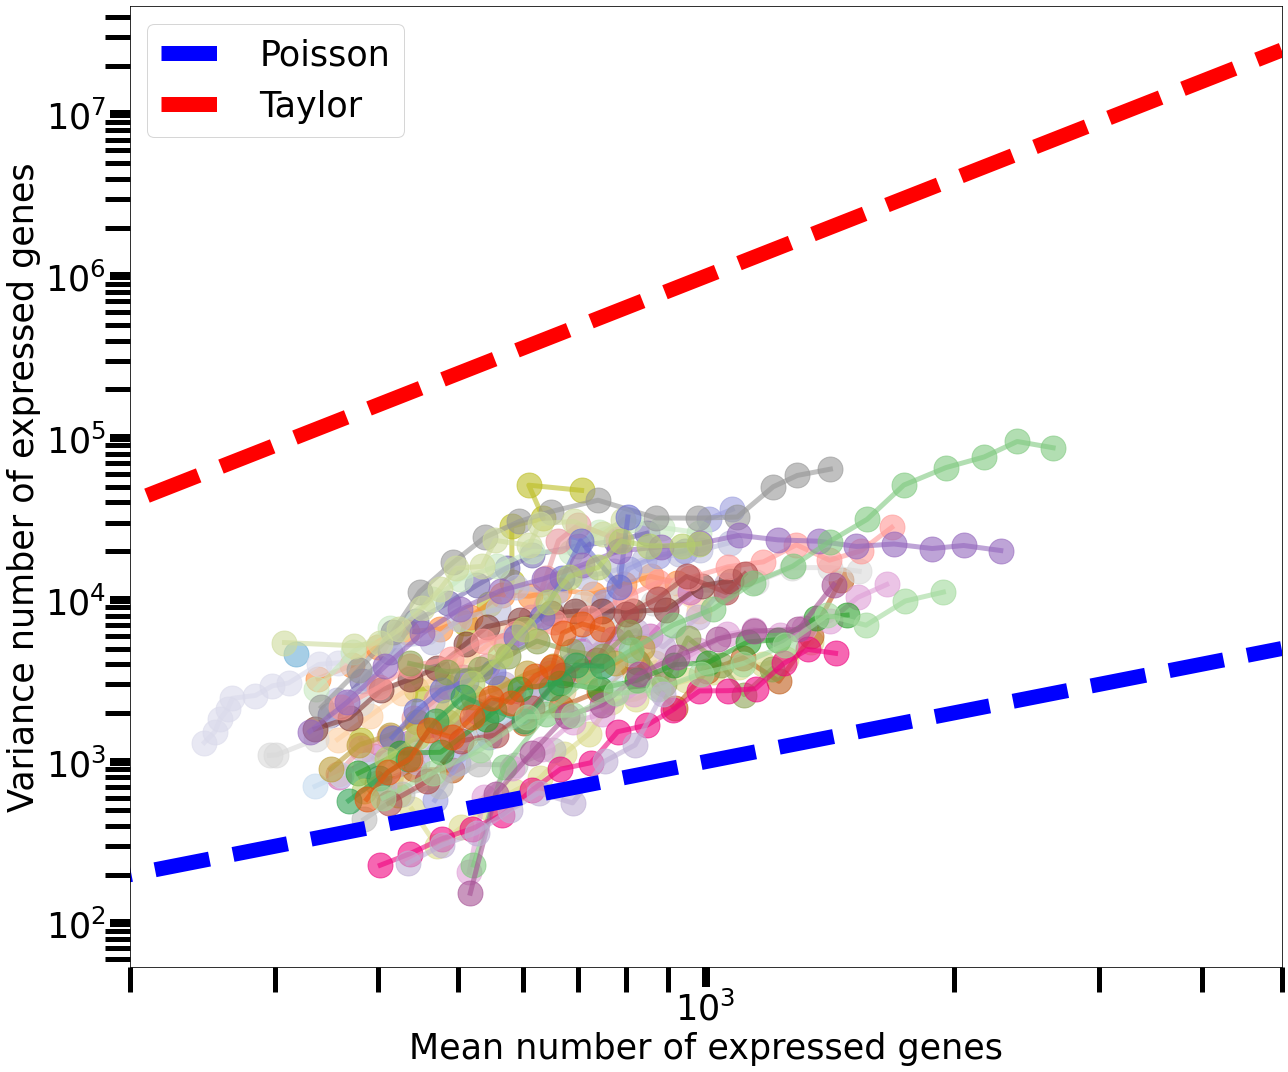

In [15]:
loglog = True
filter_mammaryLactation = True

exps = []

fig, ax = plt.subplots(figsize=(18,15))
for tissue in data["frac_of"].keys():
#for tissue in common_organs:
    try:
        info = load_tissue(tissue)
    except:
        continue
    if ("Lactation" in tissue) and filter_mammaryLactation:
        continue
    #data = load_all_data("mca")
    M = info["M"]
    diff= info["diffWords"]
    n_bins=25

    bins = np.logspace(np.log10(M.min()),np.log10(M.max()), n_bins)
    #bins = np.linspace(M.min(),max(M), n_bins)
    #bins = np.quantile(M,np.linspace(0,1, n_bins))



    bin_means, bin_edges, binnumber = stats.binned_statistic(M, diff,statistic='mean', bins=bins)
    bin_stds, _, _ = stats.binned_statistic(M, diff,statistic='std', bins=bins)
    bin_counts, _, _ = stats.binned_statistic(M, diff,statistic='count', bins=bins)

    bin_stds = np.power(bin_stds,2)

    mask = bin_counts > 1e2
    
    x = bin_means[mask]
    y = bin_stds[mask]
    popt = [1]
    try:
        popt, pcov = curve_fit(heaps_free_exponent, x,y)
        print(tissue, *popt)
        exps.append(popt[1])
    except:
        print(*sys.exc_info())
        print(tissue)
    finally:
        ax.plot(x, y, marker='o', lw=5, ms=25, alpha=0.6, c=get_color(tissue))

x = np.linspace(100,5e3)
ax.plot(x,x, lw=15,ls="--", c="blue", label="Poisson")
ax.plot(x,x*x, lw =15, ls="--", c="red", label="Taylor")
ax.set_xlabel("Mean number of expressed genes", fontsize=35)
ax.set_ylabel("Variance number of expressed genes", fontsize=35)

ax.set_xlim(200,5e3) #min UMI is 500

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)

ax.set_xscale('log')
ax.set_yscale('log')

# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(fontsize=35, ncol=1)

plt.tight_layout()
plt.show()
fig.savefig("heaps_alltissues%s_mca%s_fluctuaction.pdf"%("" if filter_mammaryLactation else "_noLactation","_loglog" if loglog else ""))

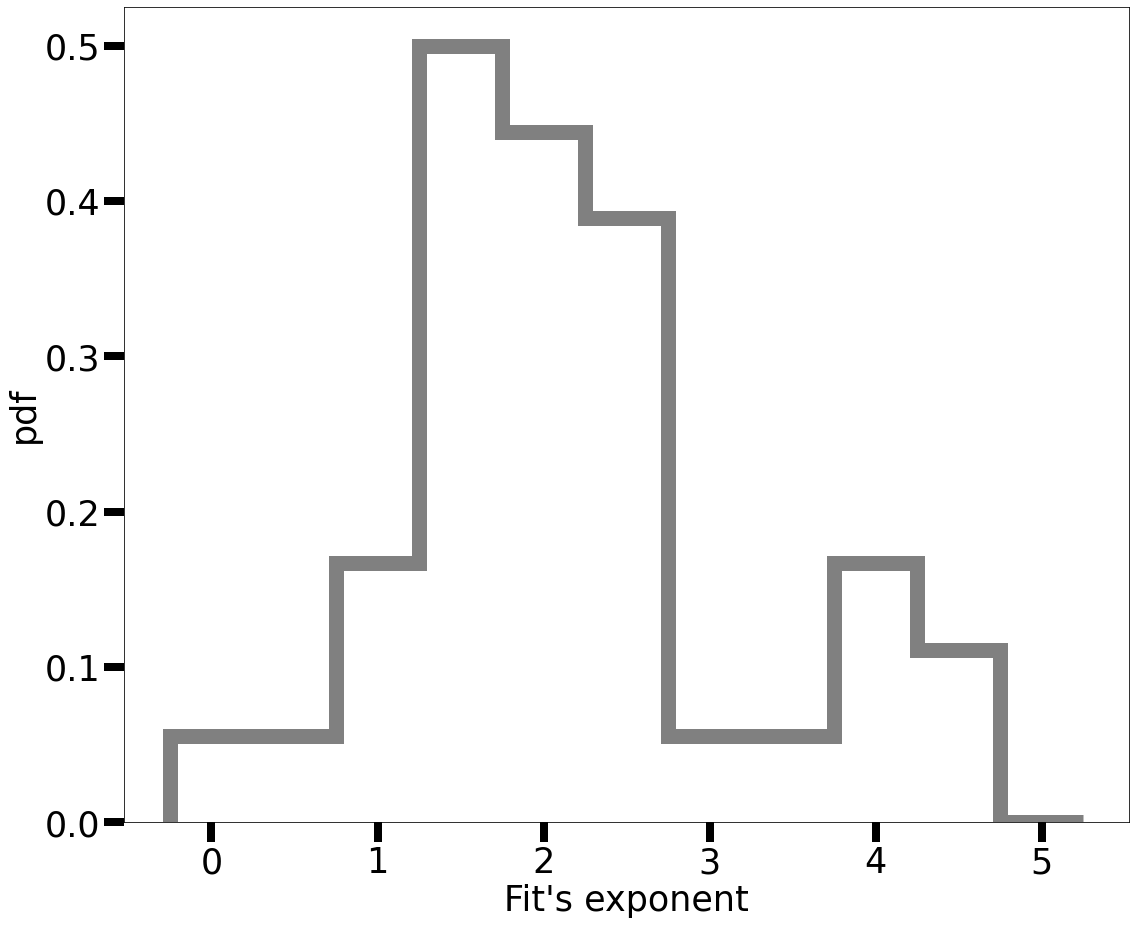

In [34]:
fig,ax=plt.subplots(figsize=(18,15))

n_bins = 10
bins = np.linspace(0-5/2/n_bins,5+5/2/n_bins,n_bins+2)
ax.hist(exps, histtype="step", density=True, color="gray", lw=15, bins=bins)

ax.set_xlabel("Fit's exponent", fontsize=35)
ax.set_ylabel("pdf", fontsize=35)
ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)
plt.show()

0.05619437250252646
[[3.82835882e-06]]


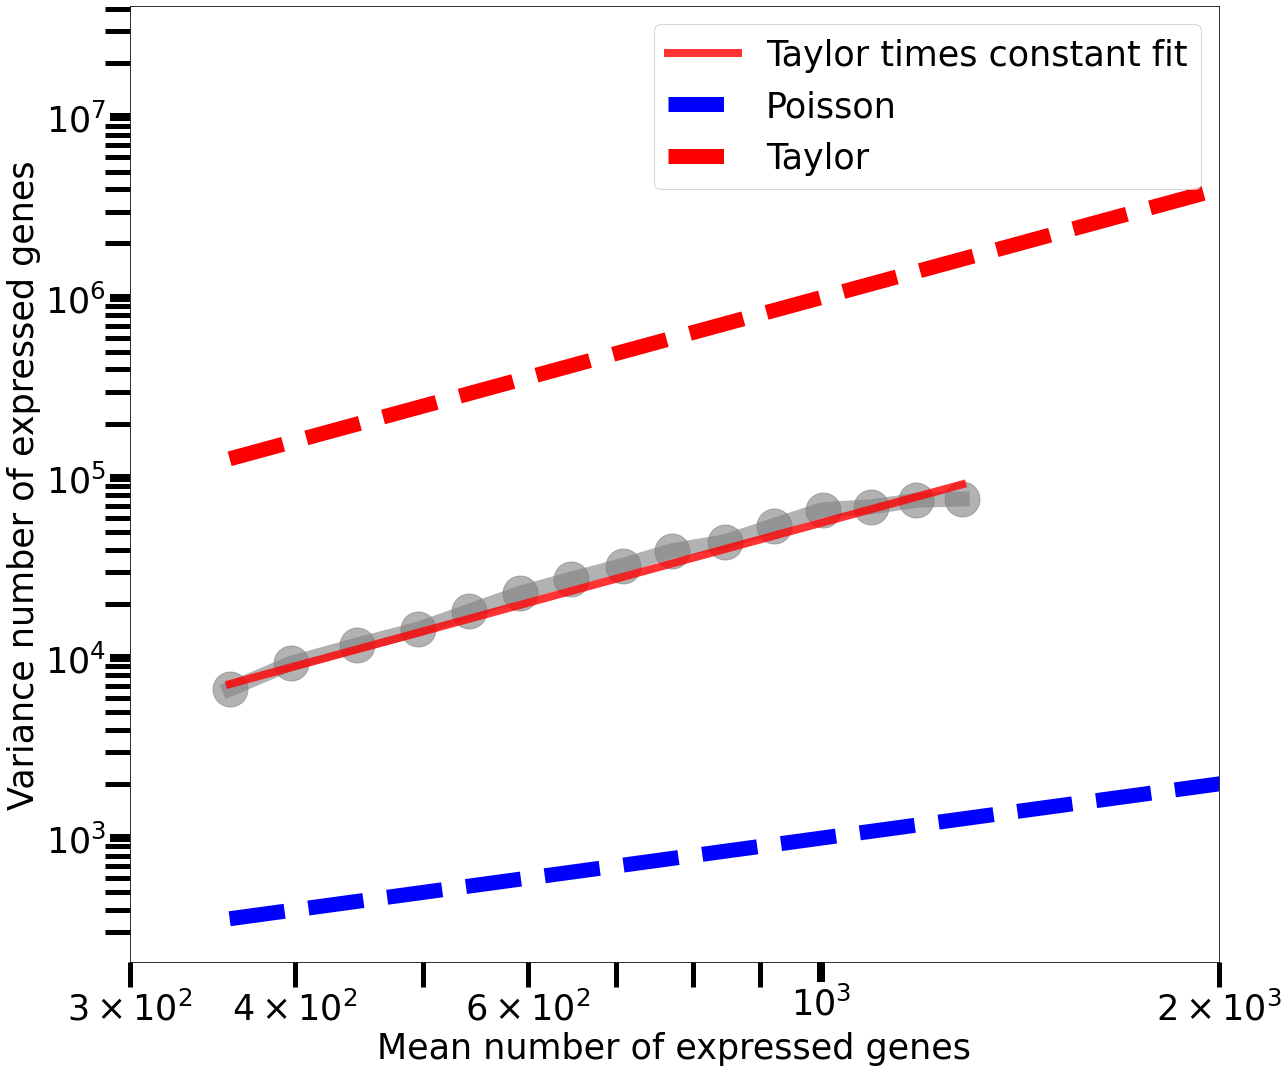

In [41]:
loglog = True
filter_mammaryLactation = True

fig, ax = plt.subplots(figsize=(18,15))
info = load_all_data("mca")
M = info["M"]
diff= info["diffWords"]
n_bins=35

bins = np.logspace(np.log10(M.min()),np.log10(M.max()), n_bins)
#bins = np.linspace(M.min(),max(M), n_bins)
#bins = np.quantile(M,np.linspace(0,1, n_bins))

bin_means, bin_edges, binnumber = stats.binned_statistic(M, diff,statistic='median', bins=bins)
bin_stds, _, _ = stats.binned_statistic(M, diff,statistic='std', bins=bins)
bin_counts, _, _ = stats.binned_statistic(M, diff,statistic='count', bins=bins)

strong_mask = bin_counts > 5e3
mask = bin_counts > 1e2

bin_stds = np.power(bin_stds,2)

x = bin_means
y = bin_stds

popt, pcov = curve_fit(heapsvar, x[strong_mask], y[strong_mask])
print(*popt)
print(pcov)

ax.plot(x[strong_mask], y[strong_mask], marker='o', lw=15, ms=35, alpha=0.6, c="gray")
ax.plot(x[strong_mask], heapsvar(x[strong_mask], *popt), lw=8, ms=25, alpha=0.8, c="red", label="Taylor times constant fit")

#ax.errorbar(x,y , bin_stds[:-skip_bins], fmt='none', ecolor='orange', elinewidth=3)

#popt, pcov = curve_fit(lambda x, C: C*x, x[(~strong_mask)*mask], y[(~strong_mask)*mask])
#print(*popt)
#print(pcov)
#ax.plot(x[~strong_mask*mask], popt[0]*x[~strong_mask*mask], lw=8, ms=25, alpha=0.8, c="blue")


ax.plot(x,x, lw=15,ls="--", c="blue", label="Poisson")
ax.plot(x,x*x, lw =15, ls="--", c="red", label="Taylor")
ax.set_xlabel("Mean number of expressed genes", fontsize=35)
ax.set_ylabel("Variance number of expressed genes", fontsize=35)

ax.set_xlim(300,2e3) #min UMI is 500

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)

ax.set_xscale('log')
ax.set_yscale('log')

# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(fontsize=35, ncol=1)

plt.tight_layout()
plt.show()
fig.savefig("heaps_alltissues%s_mca%s_fluctuaction_all.pdf"%("" if filter_mammaryLactation else "_noLactation","_loglog" if loglog else ""))

# Scaling

## CV2

In [25]:
# filter data
var = data["var"].dropna()
means = data["means"].dropna()
O = data["O"].dropna()
O = O[~O.duplicated()]
means = means[~means.duplicated()]
var = var[~var.duplicated()]
means = means[var[var>1e-7].index].dropna()
var = var.reindex_like(means)
O = O.reindex_like(means)

Use the following cell to select only coding or non-coding genes in GTEx.
**(C)** and **(D)** figures of the panel

In [29]:
assert data_source == "gtex", "Use this piece or code only for GTEx"
genes=pd.read_csv("genes_gtex.txt", header=0, index_col=0)
df_genes.head()
nc=df_genes[df_genes["type_of_gene"]!="protein-coding"].index
pc=df_genes[df_genes["type_of_gene"]=="protein-coding"].index
genelist = pd.read_csv("https://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel()
pc=pc[pc.isin(genelist)]

#select protein coding or noncoding
means = means[means.index.isin(pc)]
var = var.reindex_like(means)

AssertionError: Use this Cell only for GTEx

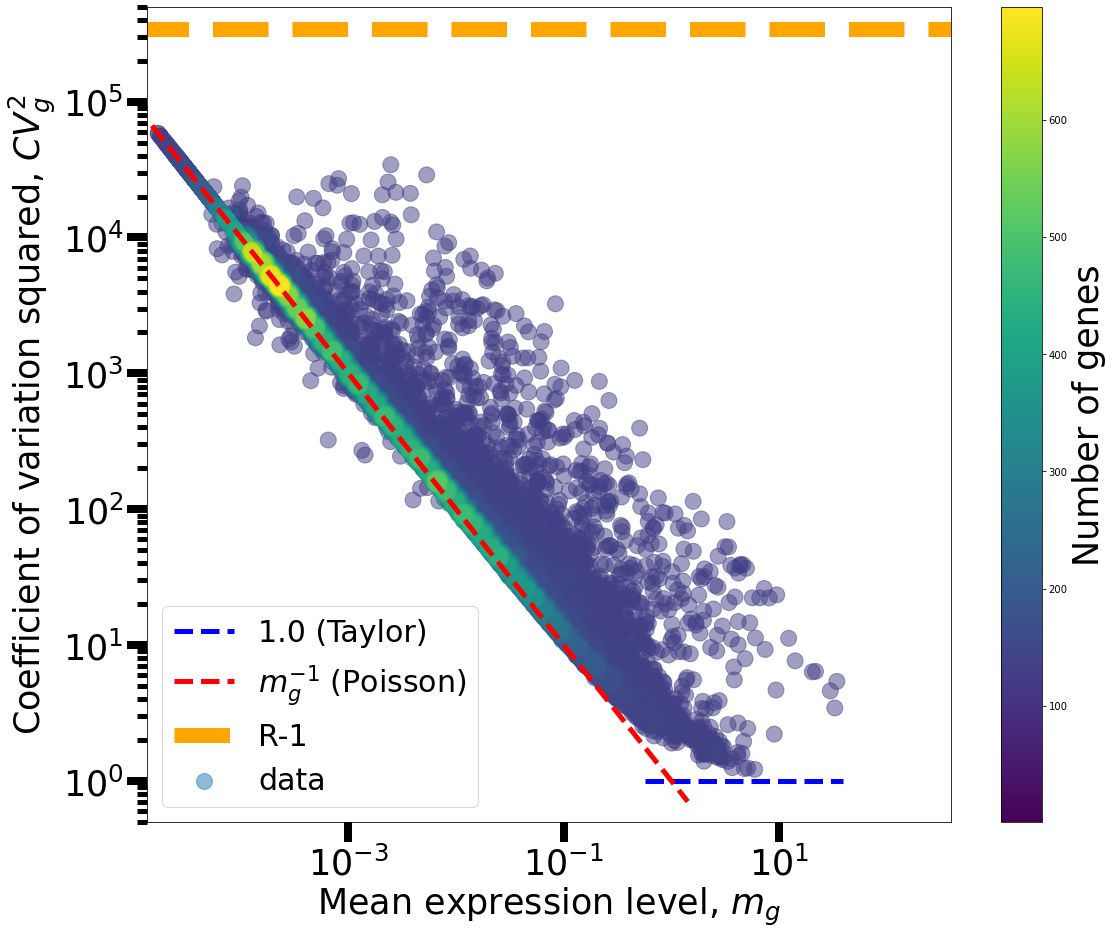

In [26]:
fig, ax = plt.subplots(figsize=(18,15))
ax.set_xlim(1e-3, 5e2)

#in GTex poisson_limit is 10
plotcv2mean(means.values.ravel(), var.values.ravel(), ax=ax, normalisation_str='counts', poisson_limit=1, alpha=0.5, s=255, colorbar=True)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(axis="both", which="minor", width=5, length=10)

upbound = len(data["M"])-1
x = np.logspace(-5,7)
ax.plot(x,[upbound for _ in x], ls="--", lw=15, c="orange", label="R-1")

ax.legend(fontsize=30)
ax.set_ylim(5e-1,5e5)
plt.show()
fig.savefig(f"cv2_mean_dense_{data_source}.pdf")

# Zipf of 100 single cell

In [31]:
df = pd.read_csv("mca/mainTable_Bone-Marrow_c-kit.csv", header=0, index_col=0)
M = df.sum(0)

In [32]:
top100 = M.sort_values(ascending=False).index[:100].values

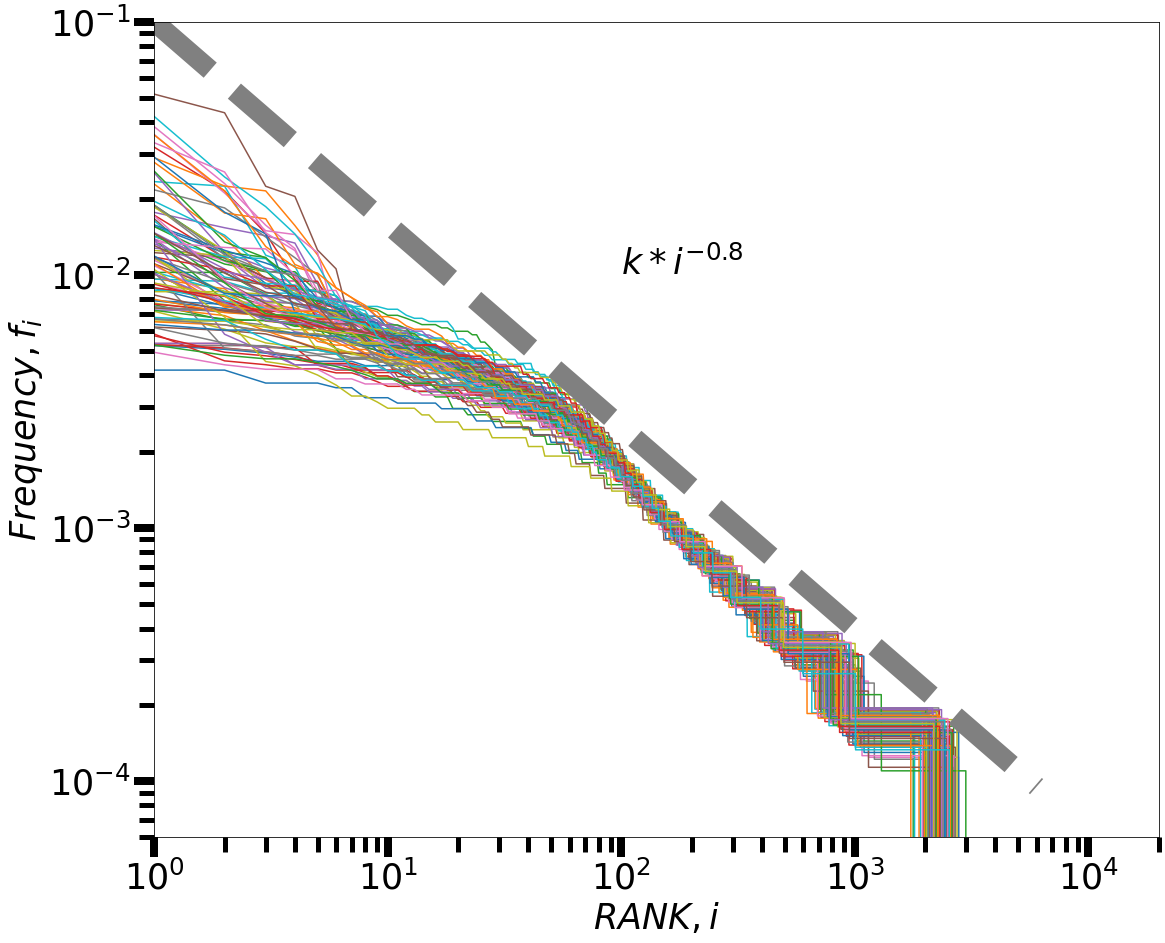

In [33]:
fig, ax = plt.subplots(figsize=(18,15))
df[df.columns[df.columns.isin(top100)]].apply(lambda x: ax.plot((x.sort_values(ascending=False)/x.sum()).values), axis=0)

x =np.linspace(1,6e3,10)

exp = 0.8
ax.plot(x, 1e-1*np.power(x, -0.8), lw=20, c='gray', ls='--')
ax.annotate('$k*i^{-%.1f}$'%exp, (1e2,1e-2), fontsize=35)


ax.set_ylabel("$Frequency, f_i$", fontsize=35)
ax.set_xlabel("$RANK, i$", fontsize=35)

ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", width=5, length=15)


ax.set_xlim(1,2e4)
ax.set_ylim(6e-5,1e-1)

plt.show()
fig.savefig("zipf_top100_mca.pdf")

# Single tissue: load data
Use the following cells to reload already analysed data for a given tissue

In [23]:
tissue = "Bone-Marrow_c-Kit"

data = load_tissue(tissue, "data")

for method in ["mazzolini"]:
    try:
        data[method] = load_tissue(tissue, method)

        means_null = data[method]['means']
        var_null = data[method]['var']
        f_null = data[method]['freq']
        f_null[np.isnan(f_null)]=0
        O_null = data[method]['O']
        M_null = data[method]["M"]
        cv2_null = data[method]['cv2']
        diffWords_null = data[method]['diffWords']
        means_nozero_null = data[method]['means_nonzero']
    except:
        print(*sys.exc_info())
    

means = data['means']
var = data['var']
f = data['freq']
O = data['O']
M = data["M"]
cv2 = data['cv2']
diffWords = data['diffWords']
means_nozero = data['means_nonzero']

In [15]:
df = pd.read_csv(f"mca/mainTable_{tissue}.csv", index_col=0, header=0)

In [16]:
M = df.sum(axis=0)
M=M.sort_values(ascending=False)

## Core Size

In [21]:
quantiles = np.quantile(M[M<4000].values, q=np.linspace(0,1,11))[:-1]
#idxs = np.linspace(500,M.max(),num=20)

sizes = {}
thetas_c = [0.8,0.85,0.9,0.95,0.99]
for theta in thetas_c:
    sizes["%.2f"%theta] = []


#for (m_, m) in zip(M[idxs].index[:-1], M[idxs].index[1:]):
for (m_,m) in zip(quantiles[:-1], quantiles[1:]):
    print(f"[{m_},{m})")
    O = df.reindex(columns=M[(m_<=M)&(M<m)].index).dropna(how="any", axis=1).apply(lambda g: len(g[g>0])/float(len(g)), axis=1)
    for theta in thetas_c:
        sizes["%.2f"%theta].append(len(O[O>theta])/len(O))
    del O

[500.0,523.0)
[523.0,554.0)
[554.0,592.0)
[592.0,641.0)
[641.0,715.0)
[715.0,818.0)
[818.0,987.0)
[987.0,1262.6000000000004)
[1262.6000000000004,1713.0)


In [22]:
q_means = (quantiles[1:]+quantiles[:-1])/2.
#q_means = (M[idxs].index[1:]+M[idxs].index[:-1])/2.

M_bin=q_means

N=df.shape[0]

def fit_teo(X_data, gamma, thetac, N=df.dropna(how="all", axis=1).shape[0]):
    """
    - gamma: Zipf exponent
    - theta_c: Occurrences thresholds
    """
    M_bin = X_data
    
    i = np.arange(1,N+1, step=1)
    alpha_i=i**(-gamma)
    alpha=np.sum(alpha_i, axis=0)
    # predicted core size 

    k=M_bin**(1/gamma)/(alpha**(1/gamma)*N)
    c=k*(-np.log(1-thetac))**(-1/gamma)
    return c

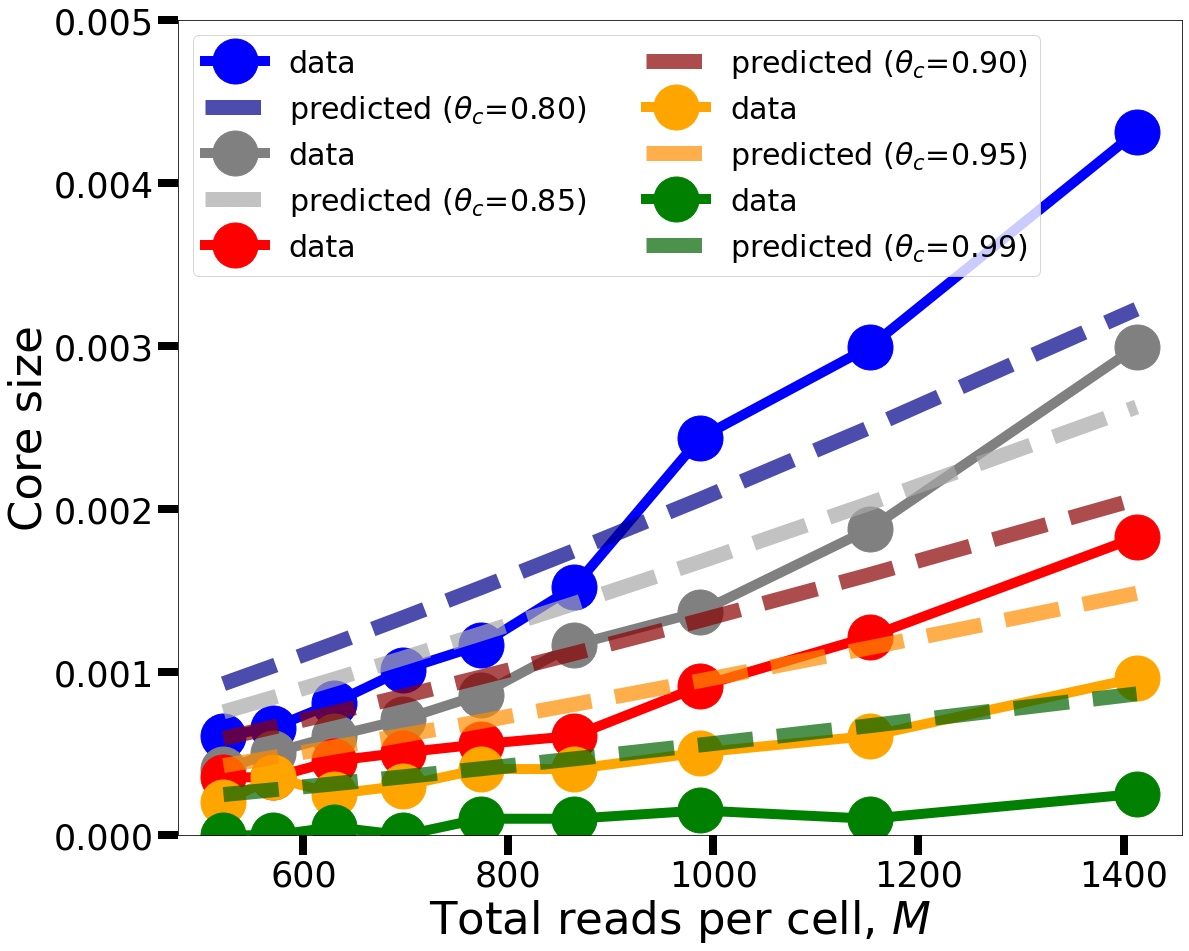

In [25]:
from scipy.optimize import curve_fit
fig,ax = plt.subplots(figsize=(18,15))

for (threshold,sizes_arr), color in zip(sizes.items(),["blue", "gray", "red", "orange", "green"]):
    ax.plot(q_means, sizes_arr, lw=10, marker="o", ms=45, c=color, label=f"data")
    popt = [0.8, float(threshold)]
    ax.plot(q_means, fit_teo(q_means, *popt), c="dark"+color, lw=15, ls="--", label="predicted ($\\theta_c$=%.2f)"%(popt[1]), alpha=0.7)

threshold = 0.9
#ax.plot(q_means, sizes["0.9"], lw=15, marker="o", ms=30, c="gray", label=f"data with thr={threshold}")


#popt, pcov = curve_fit(fit_teo, q_means, sizes["0.9"], p0=[0.8, 0.95])
popt = [0.8, 0.9]
#ax.plot(q_means, fit_teo(q_means, *popt), lw=15, ls="--", label="predicted (gamma=%.2f; thetac=%.2f)"%(popt[0],popt[1]), alpha=0.8, c="orange")

ax.set_ylim(0,0.005)

ax.set_ylabel("Core size", fontsize=45)
ax.set_xlabel("Total reads per cell, $M$", fontsize=45)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=15)

ax.legend(ncol=2,fontsize=30)
plt.show()
fig.savefig(f"U_core_prediction_{tissue}_allthr.pdf")

In [24]:
df = df[M.index]
A = df.sum(1)
f = A.sort_values(ascending=False)
#df=df[df.index.isin(f[49:4500].index)]
#save_model(df,tissue="bonemarrow_M100",name="data", n_bins=15)
#mazzolini(np.repeat(M.mean(), len(M)), A/A.sum(), "bonemarrow_M_avg", n_bins=15)

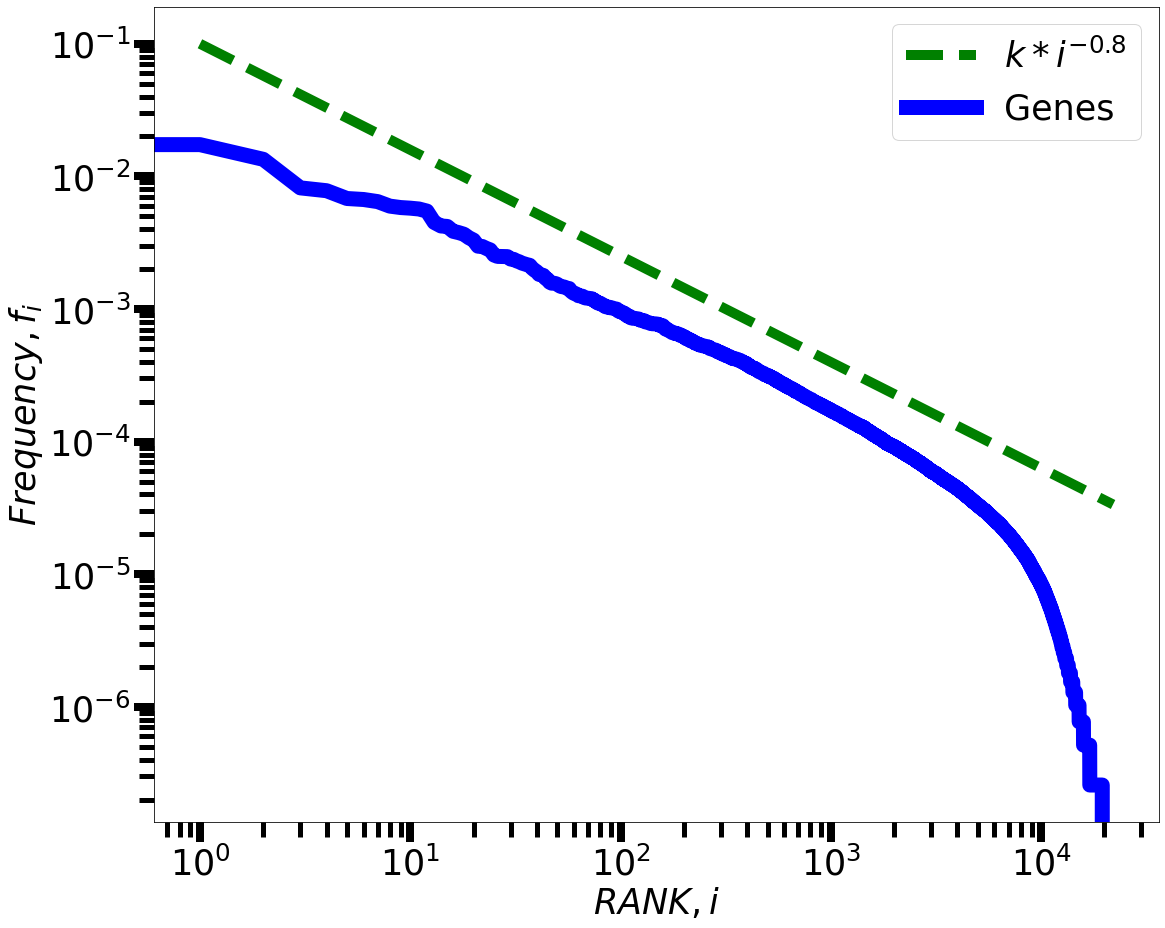

In [25]:
fig,ax = plt.subplots(figsize=(18,15))
x = np.arange(1, len(f))
ax.set_ylabel("$Frequency, f_i$", fontsize=35)
ax.set_xlabel("$RANK, i$", fontsize=35)
ax.set_yscale('log')
ax.set_xscale('log')
#plt.ylim(1e-7,1)
ax.plot(x, np.power(x,-0.8)*1e-1, 'g--', lw=10, label='$k*i^{-0.8}$')
ax.plot(np.sort(f.dropna())[::-1]/f.sum(), c='blue', lw=15, label='Genes')
if "f_null" in vars().keys():
    ax.plot(np.sort(f_null/f_null.sum())[::-1], c='orange', ls='--', lw=15, label='null_model')
    
ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=15)

ax.legend(fontsize=35)
plt.show()
fig.savefig("zipf.pdf")

## Predict O

In [7]:
#tissue = "all"
#data = load_all_data()
tissue = "Liver"
data = load_tissue(tissue)

In [8]:
P = data["freq"].values
M = data["M"].values
O = data["O"].values
R = M.shape[0]

In [9]:
O_real = np.array([])
O_pred = np.array([])
O_pred_ds = np.array([])


step = 1500
for start in range(0,len(O),step):
    print(start)
    mask = np.repeat(False, len(O))
    mask[start:start+step]=True

    O_real = np.concatenate([O_real,O[mask]])
    O_pred = np.concatenate([O_pred,list(map(lambda p: 1-1/R*np.sum(np.exp(-p*M)),P[mask]))])
    
genes = data["freq"].index[O_real < (0.8*O_pred)].values

0
1500
3000
4500
6000
7500
9000
10500
12000
13500
15000
16500
18000


In [10]:
f = data["freq"]

pos_mask = (~f.isna()) & (f>0)

g_high = f.index[O_pred > O_real + 0.2].values
g_low = f.index[O_pred < O_real * 0.6 - 0.03].values

mask_high = (f.index.isin(g_high)) & (pos_mask)
mask_low = (f.index.isin(g_low)) & (pos_mask)
#mask_nc = (f.index.isin(nc)) & (pos_mask)

f_sorted = f[f>0].sort_values(ascending=False)
mask_sorted_high = f_sorted.index.isin(g_high)
mask_sorted_low = f_sorted.index.isin(g_low)

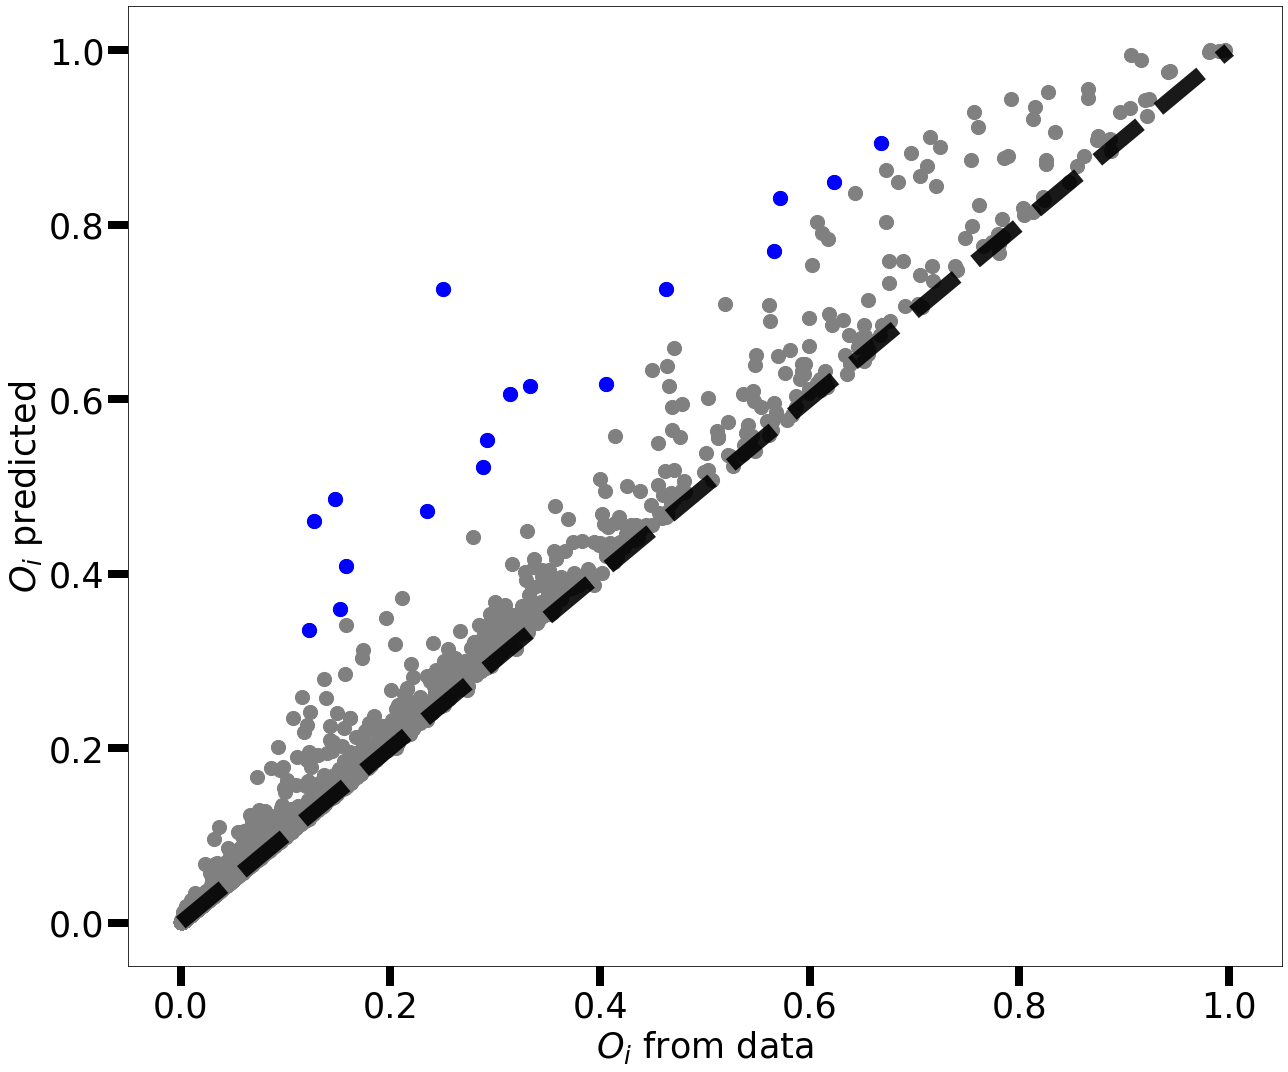

In [11]:
fig, ax = plt.subplots(figsize=(18,15))
ax.scatter(O_real, O_pred, s=200, c='gray')
ax.plot([0,1], [0,1], color = "black", ls='--', lw=15, alpha=0.9)

ax.scatter(O_real[mask_high], O_pred[mask_high], s=200, c='b')
ax.scatter(O_real[mask_low], O_pred[mask_low], s=200, c='red')

#ax.scatter(O_real[mask_nc], O_pred[mask_nc], s=200, c='red')


ax.set_xlabel("$O_i$ from data", fontsize=35)
ax.set_ylabel("$O_i$ predicted", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", width=5, length=10)

plt.tight_layout()
plt.show()
fig.savefig(f"O_real-O_pred_{tissue}.pdf")

In [12]:
with open(f"OrealOpred_overlist_{tissue}_low.txt","w") as f:
    list(map(lambda g: f.write(g+"\n"), filter(lambda g: "Rik" not in g, data["freq"].index.values[mask_low])))

In [21]:
# theoretical prediction
def h(m, gamma: list, N, F1=122, F2=4100):
    g1, g2 = gamma
    i = np.arange(1, N+1, step=1)
    
    b = 1./(F1**(g1-g2)*np.sum([_i**(-g1) for _i in i[:F1]])+np.sum([_i**(-g2) for _i in i[F1:F2]]) + (F2**(-g2))*np.exp(0.002*F2)*np.sum([np.exp(-0.002*_i) for _i in i[F2:]]))
    c = b * (F2**(-g2))*np.exp(0.002*F2)
    a = b * F1**(g1-g2)
    return N - np.sum((1-a*np.power(i[:F1], -g1))**m, axis=0) - np.sum((1-b*np.power(i[F1:F2], -g2))**m, axis=0) - np.sum((1-c*np.exp(-0.002*i[F2:]))**m, axis=0)

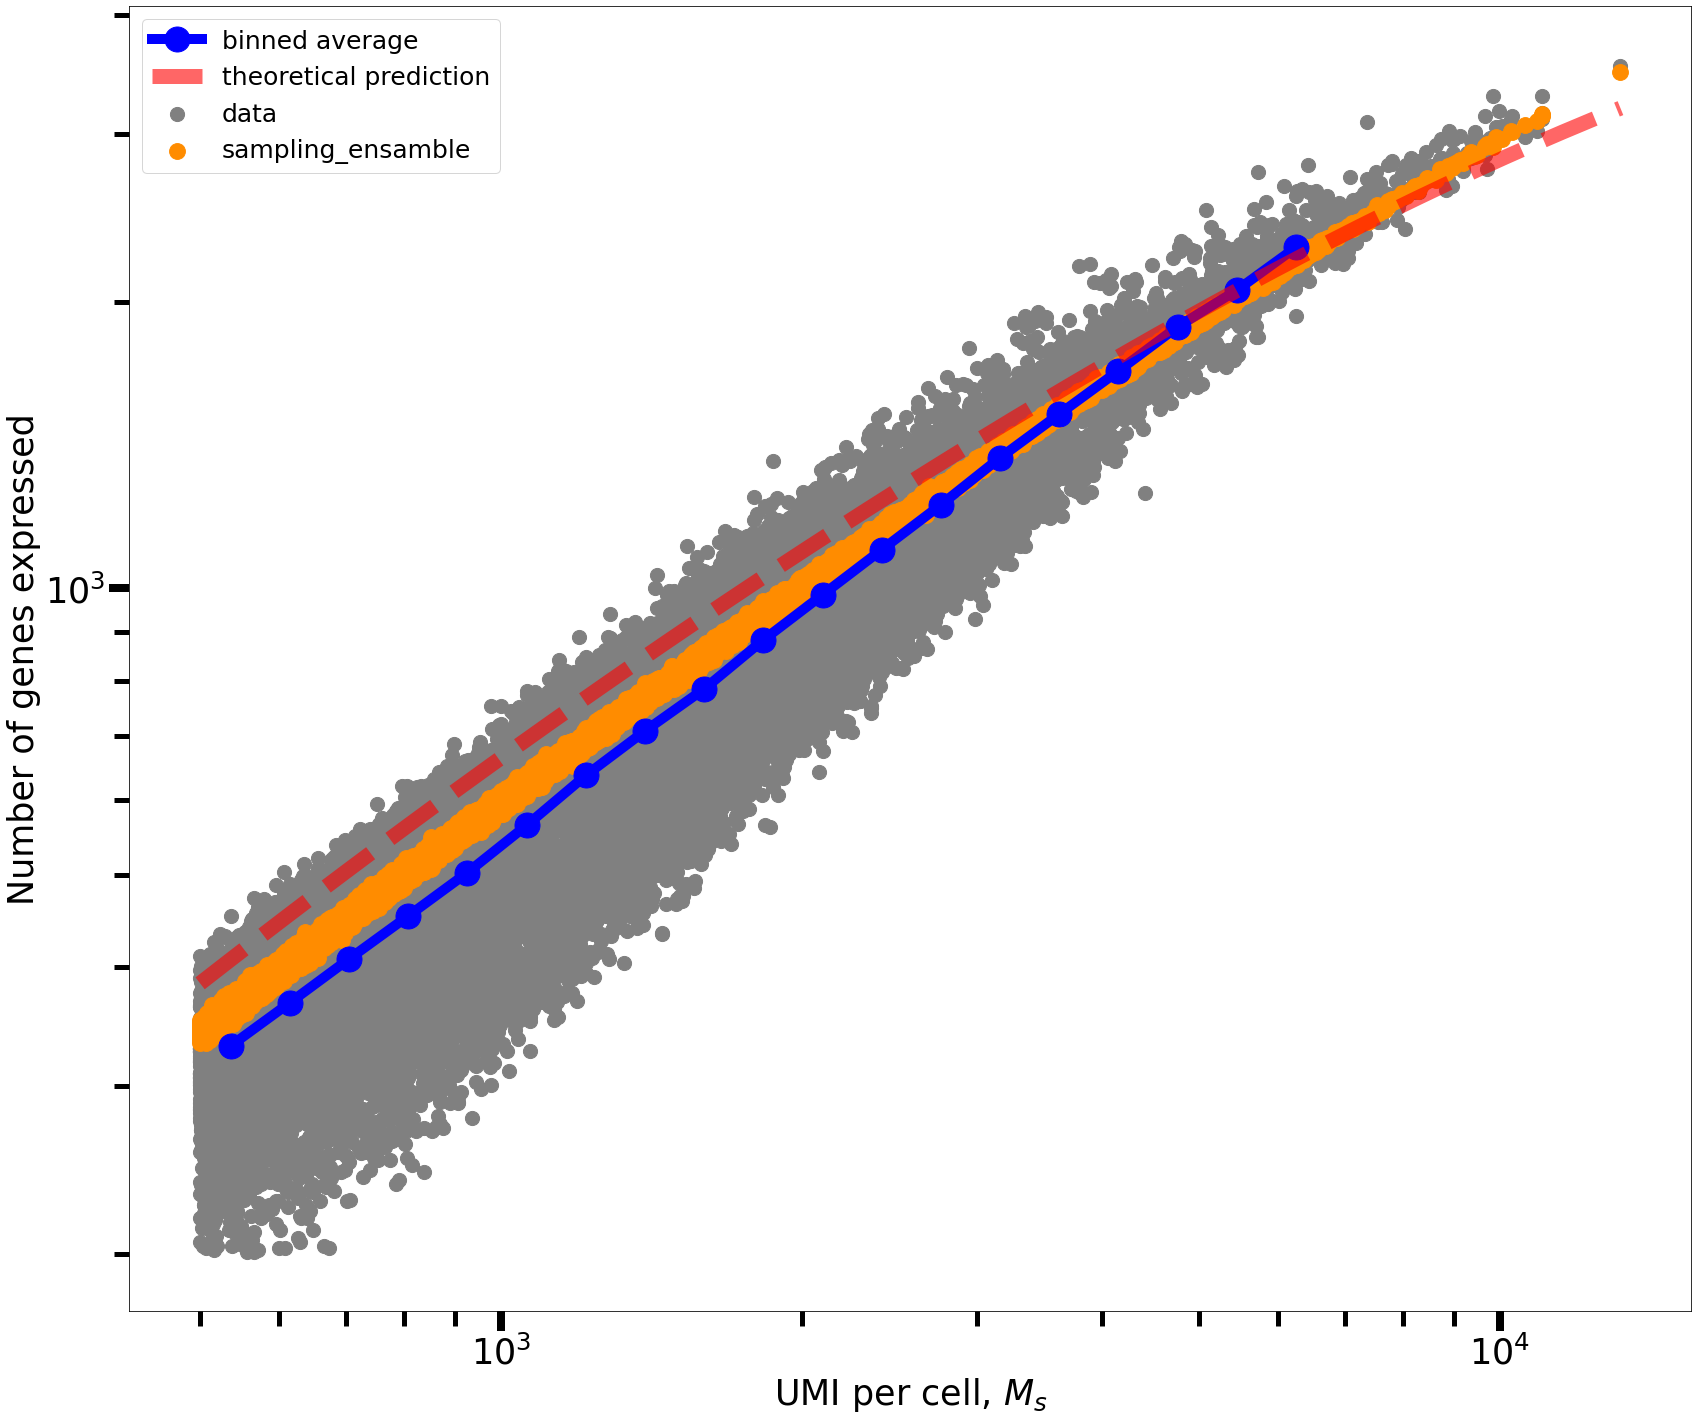

In [ ]:
fig, ax = plt.subplots(figsize=(28,24))

skip_bins=5
ax.scatter(data["M"], data["diffWords"], color="gray", s=200, label="data")

ax.scatter(data["mazzolini"]["M"], data["mazzolini"]["diffWords"], color="darkorange", s=250, label="sampling_ensamble")


bin_means, bin_edges, binnumber = stats.binned_statistic(data["M"], data["diffWords"],statistic='mean', bins=np.logspace(np.log10(data["M"].min()),np.log10(max(data["M"])), 25))

ax.plot((bin_edges[:-1][:-skip_bins] + bin_edges[1:][:-skip_bins])/2, bin_means[:-skip_bins], color='blue', lw=10, marker="o", ms=25, label='binned average')


x_bins=np.logspace(np.log10(data["M"].min()),np.log10(max(data["M"])))
ax.plot(x_bins, [h(x, [0.5, 1.0], len(data["freq"].dropna()), F1=122, F2=4100) for x in x_bins], lw=15, alpha=0.6, ls="--", c="red", label="theoretical prediction")

ax.set_ylabel("Number of genes expressed", fontsize=35)
ax.set_xlabel("UMI per cell, $M_s$", fontsize=35)
ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=15)

ax.legend(fontsize=25)

ax.set_xscale("log")
ax.set_yscale("log")

plt.show()
fig.savefig(f"heaps_{tissue}_mazzolini_teo.pdf")